In [1]:
import spacy
import asent
import textdescriptives
import empath
import tqdm
import re
import warnings
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import decomposition, discriminant_analysis 
from matplotlib import pyplot as plt, lines
from constants import *
plt.style.use("minimal")
# plt.style.use("minimal.mplstyle")

In [2]:
def load_data():
    global database
    database = pd.read_parquet("database.parquet")
    # database["substance"] = pd.Categorical(database["substance"], ("DMT", "LSD", "Psilocybin", "MDMA"))
    database["substance"] = pd.Categorical(database["substance"], colormap.keys())
    database["substance_ID"] = database["substance"].cat.codes
    # database["time_of_experience"] = pd.to_datetime(database["time_of_experience"].str.split("-").str[0], format = "%Y", errors = "coerce")
    database["time_of_submission"] = pd.to_datetime(database["time_of_submission"], format = "%b %d, %Y", errors = "coerce")
    database["age_at_experience"] = database["age_at_experience"].replace({"Not Given": pd.NA})
    database["gender"] = database["gender"].replace({"not specified": pd.NA})
    database["content"] = database["content"].fillna("").str.replace(r"<[^>]+>|\[Erowid Note:([\s\S]*)\]|\n|\r|<br>", " ", regex=True)
    database = database[database["content"].str.strip() != ""]
    # database["content_sanitized"] = database["content"].str.replace(" | ".join(alternative_names), " ", regex = True, flags = re.IGNORECASE).str.replace("[^A-Za-z0-9 -]+", "", regex = True)
    database = database.reset_index(drop = True)

load_data()
BASE_COLUMNS = database.columns
database.sample(5)

,experience_ID,author,substance,content,time_of_experience,time_of_submission,age_at_experience,gender,substance_ID
1450,45364,terica,Psilocybin,After eating a couple of shrooms (3-4 stems??)...,2004,2005-11-01,<NA>,female,6
4644,34345,Anon,Salvinorin A,This is the ultimate experience. Salvia is how...,2004,NaT,Not Given,male,1
473,49957,San Pedro,MDMA,We had been preparing for my friend R's 16th b...,2006,2018-02-18,<NA>,male,7
4156,17986,MS,Salvinorin A,The experience presented here took me by a com...,2002,NaT,Not Given,male,1
63,101879,Double D,MDMA,"When I took MDMA for the first time, I was a s...",2013,2019-09-16,18,female,7


In [3]:
print(len(database), "reports")
print(pd.DataFrame(database["substance"].value_counts()))
print(pd.DataFrame(database["gender"].value_counts()))

5627 reports
              substance
LSD                1177
Psilocybin         1103
DMT                 630
Salvinorin A        609
MDMA                569
Ketamine            344
5-MeO-DMT           257
Ibogaine             29
        gender
male      4109
female    1150


In [4]:
empath_lexicon = empath.Empath()
empath_lexicon.load("categories.empath")

@spacy.language.Language.component("empath_client")
def empath_client(doc):
    if not doc.has_extension("empath"):
        doc.set_extension("empath", default = dict())
    doc._.empath = empath_lexicon.analyze(" ".join([token.text.lower() for token in doc]), normalize=True)
    return doc

empath_category_subset = [
    "self", 
    "other", 
    "be", 
    "have", 
    "ego", 
    "space", 
    "spirituality", 
    "visual", 
    "sex", 
    "time", 
    "emotion", 
    "nature", 
    "sound", 
    "body", 
    "relationship", 
    "mystical",
]
empath_lexicon.cats.keys()

dict_keys(['help', 'office', 'dance', 'money', 'wedding', 'domestic_work', 'sleep', 'medical_emergency', 'cold', 'hate', 'cheerfulness', 'aggression', 'occupation', 'envy', 'anticipation', 'family', 'vacation', 'crime', 'attractive', 'masculine', 'prison', 'health', 'pride', 'dispute', 'nervousness', 'government', 'weakness', 'horror', 'swearing_terms', 'leisure', 'suffering', 'royalty', 'wealthy', 'tourism', 'furniture', 'school', 'magic', 'beach', 'journalism', 'morning', 'banking', 'social_media', 'exercise', 'night', 'kill', 'blue_collar_job', 'art', 'ridicule', 'play', 'computer', 'college', 'optimism', 'stealing', 'real_estate', 'home', 'divine', 'sexual', 'fear', 'irritability', 'superhero', 'business', 'driving', 'pet', 'childish', 'cooking', 'exasperation', 'religion', 'hipster', 'internet', 'surprise', 'reading', 'worship', 'leader', 'independence', 'movement', 'body', 'noise', 'eating', 'medieval', 'zest', 'confusion', 'water', 'sports', 'death', 'healing', 'legend', 'heroic

In [5]:
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("sentencizer")
nlp.add_pipe("asent_en_v1")
nlp.add_pipe("textdescriptives/all")
nlp.add_pipe("empath_client")
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'sentencizer',
 'asent_en_v1',
 'textdescriptives/coherence',
 'textdescriptives/dependency_distance',
 'textdescriptives/descriptive_stats',
 'textdescriptives/pos_proportions',
 'textdescriptives/quality',
 'textdescriptives/readability',
 'textdescriptives/information_theory',
 'textdescriptives/all',
 'empath_client']

In [6]:
database.columns

Index(['experience_ID', 'author', 'substance', 'content', 'time_of_experience',
       'time_of_submission', 'age_at_experience', 'gender', 'substance_ID'],
      dtype='object')

In [7]:
# load_data()
# # database = database.sample(10)

# sentiment_dimensions = ["sentiment", "sentiment_neg", "sentiment_neu", "sentiment_pos"]
# empath_dimensions = list(empath_lexicon.cats.keys())

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     docs = list(tqdm.tqdm(nlp.pipe(database["content"]), total = len(database)))

#     database["vector"] = [doc.vector for doc in docs]
#     database[["sentiment", "sentiment_neg", "sentiment_neu", "sentiment_pos"]] = [(doc._.polarity.compound, doc._.polarity.negative, doc._.polarity.neutral, doc._.polarity.positive) for doc in docs]
#     database[empath_dimensions] = [[doc._.empath[cat] for cat in empath_dimensions] for doc in docs]
#     database = pd.concat([database, textdescriptives.extractors.extract_df(docs, include_text = False)], axis = 1)

# database.to_parquet("database_processed.parquet")

In [8]:
database = pd.read_parquet("database_processed.parquet")
database.sample(5)

,experience_ID,author,substance,content,time_of_experience,time_of_submission,age_at_experience,gender,substance_ID,vector,...,pos_prop_SCONJ,pos_prop_SYM,pos_prop_VERB,pos_prop_X,dependency_distance_mean,dependency_distance_std,prop_adjacent_dependency_relation_mean,prop_adjacent_dependency_relation_std,first_order_coherence,second_order_coherence
4357,10775,pptt,Salvinorin A,After a lot of explorations online ...,2000,NaT,Not Given,male,1,"[-1.6388034, 1.1626548, -2.6047254, -1.0909736...",...,0.032340,0.000000,0.121702,0.000000,2.903366,0.711017,0.431553,0.065041,0.777275,0.790991
4499,940,NQU,Salvinorin A,My experiences with diviner's sage were not wh...,2000,NaT,Not Given,None,1,"[-1.665788, 0.8946398, -2.405192, -0.7221106, ...",...,0.028522,0.000000,0.133103,0.000000,2.606284,0.597844,0.473649,0.082776,0.776836,0.780923
2714,92991,Steve E.,LSD,In Steven Spielbergs celebrated sci-fi fantas...,1973,2018-04-19,15,male,5,"[-2.258716, 0.06663111, -1.6323777, 0.07055616...",...,0.018612,0.001006,0.110664,0.000503,2.969203,0.879738,0.450508,0.069043,0.792885,0.785408
570,104360,Imaginary,Psilocybin,We were at my friends condo at the beach. It ...,2014,2021-01-01,23,male,6,"[-1.2953509, 1.0475452, -2.9792812, -1.1670519...",...,0.029651,0.000000,0.143023,0.000872,2.479084,0.762300,0.437687,0.079055,0.755355,0.746750
4230,55914,Chad,Salvinorin A,Having been exposed to Salvia roughly two mont...,2006,NaT,Not Given,male,1,"[-1.6405149, 0.9001623, -2.8158572, -0.4899895...",...,0.031760,0.000000,0.117597,0.000000,3.022826,0.768362,0.453906,0.053089,0.840210,0.844003


In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dimensions_to_standardize = [col for col in database.select_dtypes(include="number") if not col in BASE_COLUMNS and not col.endswith("_Z")]
    database[[f"{col}_Z" for col in dimensions_to_standardize]] = database[dimensions_to_standardize].apply(stats.zscore, ddof = 1)

In [10]:
def column_print(lst, width = 10, rows = 20):
    for row in np.array_split(list(lst), rows):
        print("".join([(cat[:width] + ("..." if len(cat) > 10 else "")).ljust(width + 5) for cat in row]))

# column_print(dimensions_to_standardize, width = 30, rows = 50)
for dim in list(dict.fromkeys(dimensions_to_standardize)):
    print(dim)

sentiment
sentiment_neg
sentiment_neu
sentiment_pos
help
office
dance
money
wedding
domestic_work
sleep
medical_emergency
cold
hate
cheerfulness
aggression
occupation
envy
anticipation
family
vacation
crime
attractive
masculine
prison
health
pride
dispute
nervousness
government
weakness
horror
swearing_terms
leisure
suffering
royalty
wealthy
tourism
furniture
school
magic
beach
journalism
morning
banking
social_media
exercise
night
kill
blue_collar_job
art
ridicule
play
computer
college
optimism
stealing
real_estate
home
divine
sexual
fear
irritability
superhero
business
driving
pet
childish
cooking
exasperation
religion
hipster
internet
surprise
reading
worship
leader
independence
movement
body
noise
eating
medieval
zest
confusion
water
sports
death
healing
legend
heroic
celebration
restaurant
violence
programming
dominant_heirarchical
military
neglect
swimming
exotic
love
hiking
communication
hearing
order
sympathy
hygiene
weather
anonymity
trust
ancient
deception
fabric
air_travel
f

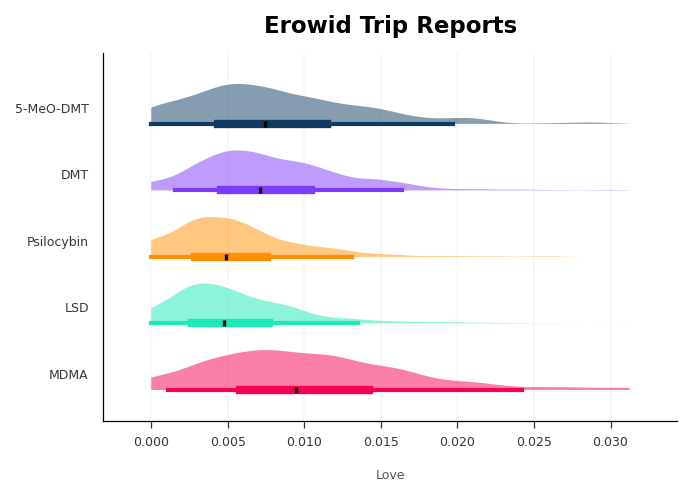

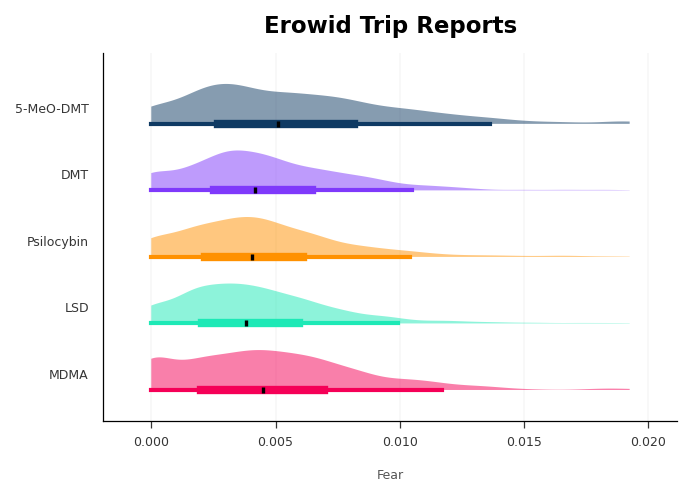

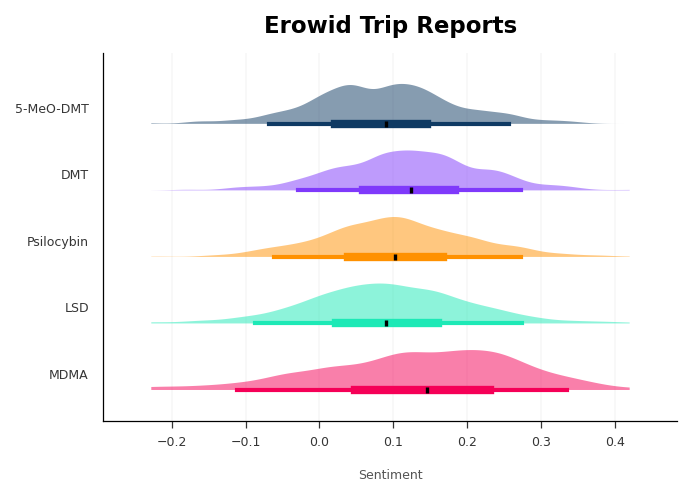

In [11]:
def compare_substances(dimension, substance_subset = None, standardize = False):
    data = database[database["substance"].isin(substance_subset)] if substance_subset else database
    data = data.dropna(subset = "substance")

    if standardize:
        dimension += "_Z"

    data_range = data[dimension].agg(("min", "max"))
    x_range = np.linspace(*data[dimension].quantile((0.005, 0.995)), num = 1000)

    for substance_idx, (substance, subset) in enumerate(data.groupby("substance", observed = True)[dimension]):
        substance_idx -= 0.25
        estimation = stats.gaussian_kde(subset, bw_method = 0.2)(x_range)
        plt.fill_between(
            x_range, 
            substance_idx,
            substance_idx + 0.6 * (estimation / estimation.max()),
            color = colormap[substance],
            label = substance,
            alpha = 0.5,
            edgecolor = "none",
        )

        for interval, linewidth in zip((0.5, 0.9), (4, 2)):
            plt.plot(
                np.quantile(subset, ((1 - interval) / 2, 1 - (1 - interval) / 2)),
                [substance_idx, substance_idx],
                linewidth = linewidth,
                color = colormap[substance],
                # color = "black",
            )
        plt.scatter(
            [np.median(subset)],
            [substance_idx],
            color = "black",
            marker = "|",
            s = 10,
            zorder = 2,
        )

    # plt.axvline(x = 0, linewidth = 0.5, color = "grey", alpha = 0.5, zorder = -1)

    plt.yticks(range(len(data["substance"].unique())), data["substance"].unique())
    plt.tick_params(left = False)
    plt.margins(x=0.1, y = 0.1)
    plt.xlabel(dimension.capitalize())
    plt.ylabel("")
    plt.title("Erowid Trip Reports")
    plt.grid(True, axis = "x", which = "both")
    plt.grid(False, axis = "y")

    plt.show()

for dimension in ("love", "fear", "sentiment"):
    # compare_substances(dimension)
    compare_substances(
        dimension, 
        substance_subset=("MDMA", "Psilocybin", "LSD", "DMT", "5-MeO-DMT"),
        # standardize=True,
    )

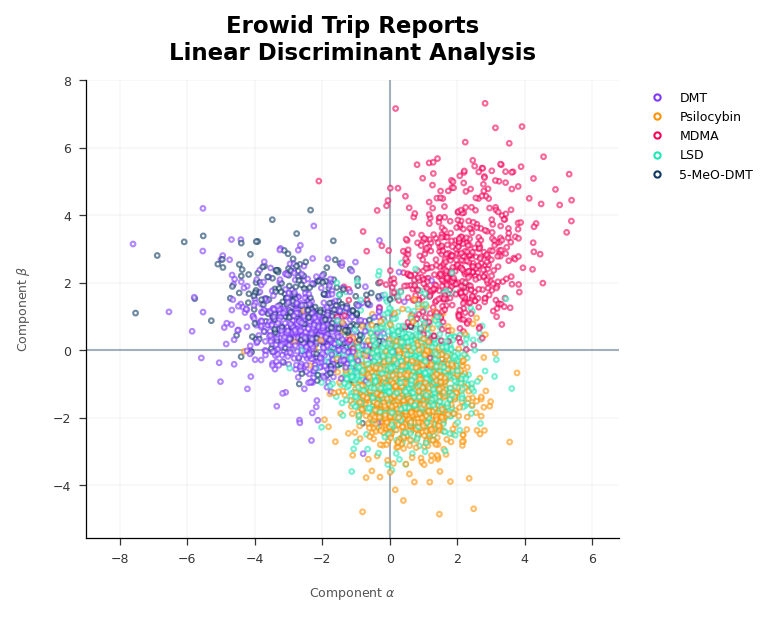

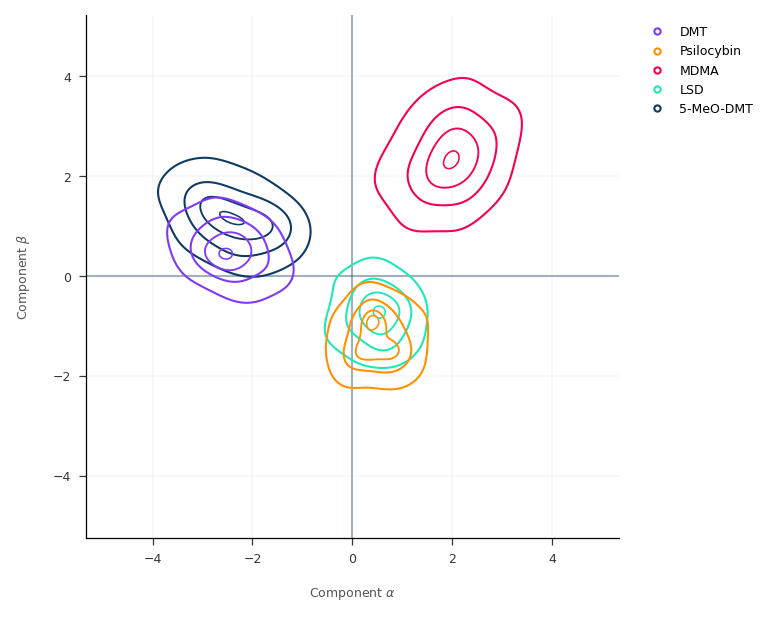

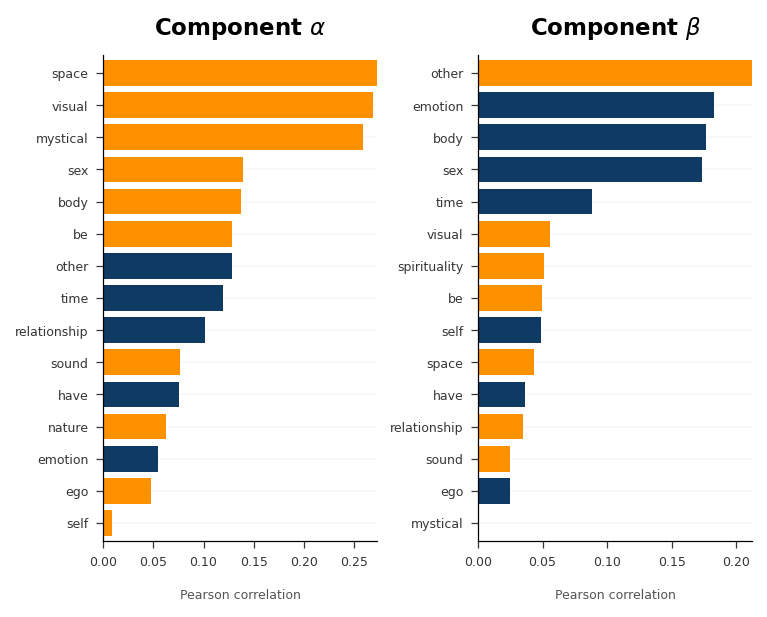

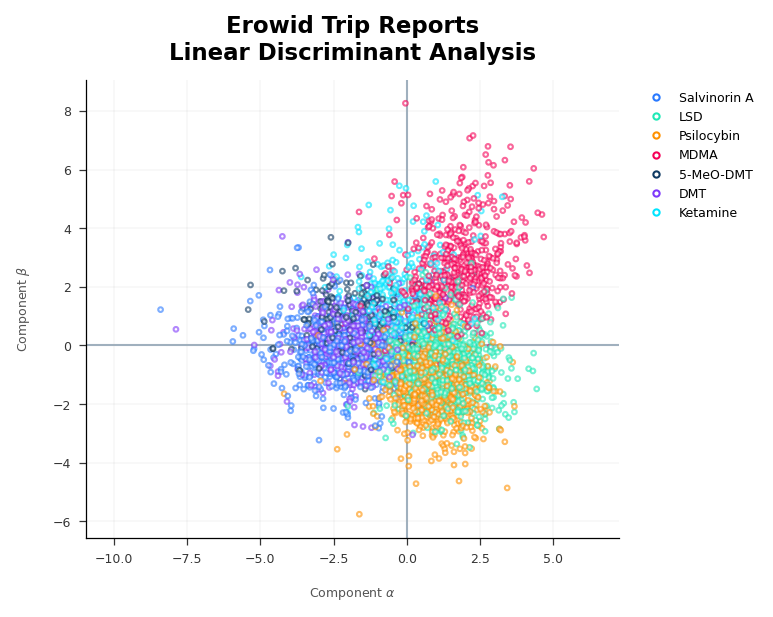

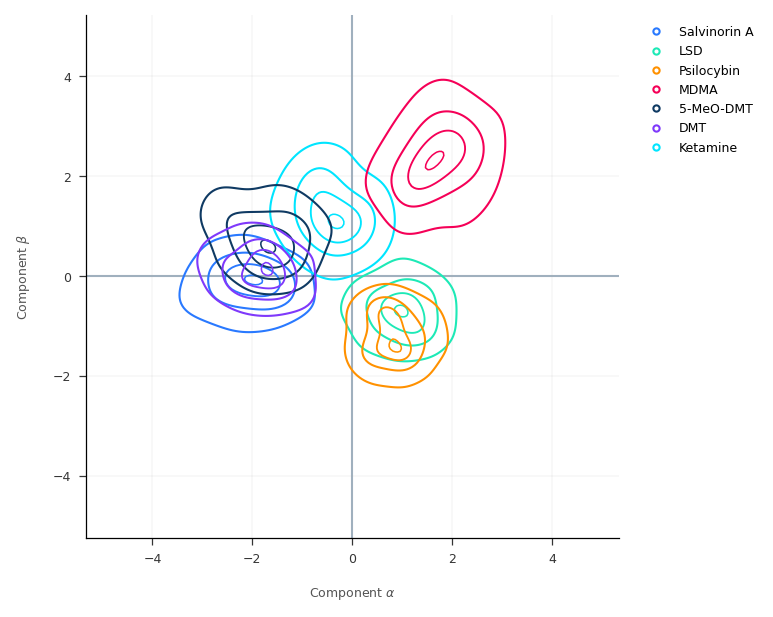

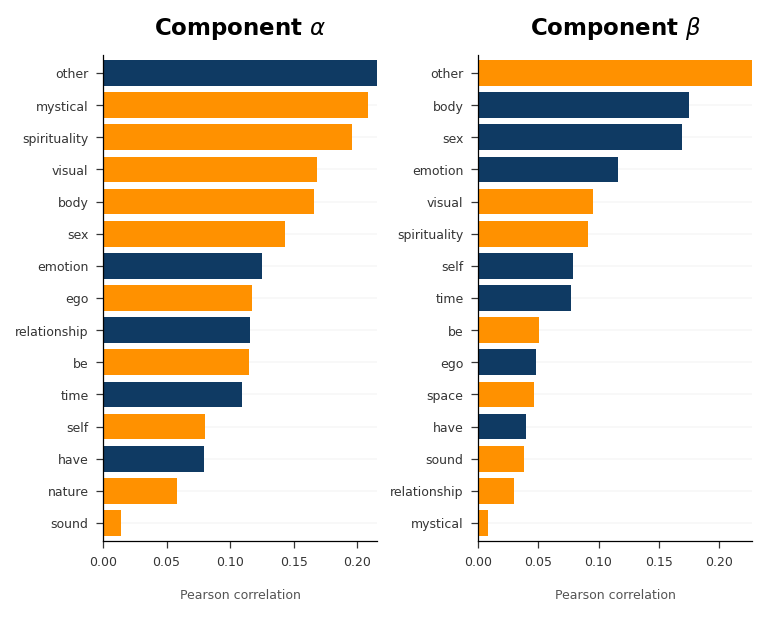

In [13]:
def decompose(n_components = 2, method = "LDA", substance_subset = None, show_loadings = False):
    data = database[database["substance"].isin(substance_subset)] if substance_subset else database
    data = data.sample(frac = 1) 
    data = data.dropna(subset = "substance")

    decomposer = dict(
        LDA = discriminant_analysis.LinearDiscriminantAnalysis, # https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html
        PCA = decomposition.PCA,
        ICA = decomposition.FastICA,
    )[method]
    
    if method == "LDA": # supervised: needs class labels
        data[[f"comp_{idx}" for idx in range(n_components)]] = decomposer(n_components=n_components).fit_transform([vec for vec in data["vector"]], data["substance"])
    else:
        data[[f"comp_{idx}" for idx in range(n_components)]] = decomposer(n_components=n_components).fit_transform([vec for vec in data["vector"]])

    fig, ax = plt.subplots(figsize=(5, 4))

    ax.scatter(
        data["comp_0"], 
        data["comp_1"], 
        color = "white",
        edgecolor = data["substance"].map(colormap),
        s = 5,
        alpha = 0.6,
        clip_on = False,
    )

    ax.legend(
        handles = [lines.Line2D([], [], marker="o", color="w", label=substance, markeredgecolor=colormap.get(substance), markersize=3) for substance in data["substance"].unique()],
        loc = "upper center", 
        bbox_to_anchor = (1.15, 1), 
    )

    ax.axvline(x = 0, linewidth = 1, alpha = 0.4, zorder = -1)
    ax.axhline(y = 0, linewidth = 1, alpha = 0.4, zorder = -1)

    ax.set_xlabel(r"Component $\alpha$")
    ax.set_ylabel(r"Component $\beta$")
    ax.set_title("Erowid Trip Reports\n" + dict(LDA = "Linear Discriminant Analysis", PCA = "Principal Component Analysis", ICA = "Independent Component Analysis")[method])

    ax.grid(True, which="both")
    ax.margins(x = 0.1, y = 0.1)
    ax.axis("equal")
    ax.set_aspect("equal", "datalim")

    fig, ax = plt.subplots(figsize=(5, 4))

    contour_levels = [0.5, 0.75, 0.9, 0.99, 1]
    ax = sns.kdeplot(
        ax = ax,
        data = data,
        x = "comp_0",
        y = "comp_1",
        hue = "substance",
        palette = colormap,
        common_norm = False,
        levels = contour_levels,
        linewidths = contour_levels[::-1],
    )

    ax.legend(
        handles = [lines.Line2D([], [], marker="o", color="w", label=substance, markeredgecolor=colormap.get(substance), markersize=3) for substance in data["substance"].unique()],
        loc = "upper center", 
        bbox_to_anchor = (1.15, 1), 
    )

    ax.axvline(x = 0, linewidth = 1, alpha = 0.4, zorder = -1)
    ax.axhline(y = 0, linewidth = 1, alpha = 0.4, zorder = -1)

    ax.set_xlabel(r"Component $\alpha$")
    ax.set_ylabel(r"Component $\beta$")

    ax.grid(True, which="both")
    ax.axis("equal")
    ax.set_ylim(-4, 4)
    ax.set_xlim(-4, 4)
    ax.margins(x = 0.1, y = 0.1)

    fig, axes = plt.subplots(figsize=(5, 4), ncols = 2)
    for component, ax in enumerate(axes):
        component_name = f"comp_{component}"
        # loadings = data[[component_name] + [cat for cat in empath_lexicon.cats.keys()]].corr(method = "spearman")[component_name].drop(component_name).reset_index()
        loadings = data[[component_name] + empath_category_subset].corr(method = "spearman")[component_name].drop(component_name).reset_index()
        loadings["abs"] = loadings[component_name].abs()
        loadings = loadings.sort_values("abs").head(15)
        ax.barh(loadings["index"], loadings["abs"], color = loadings[component_name].apply(lambda val: "C0" if val > 0 else "C1"))
        ax.set_title("Component " + {0: r"$\alpha$", 1: r"$\beta$"}[component])
        ax.set_xlabel("Pearson correlation")
        ax.margins(y = 0.01)

    plt.show()

# decompose()
decompose(substance_subset=("MDMA", "Psilocybin", "LSD", "DMT", "5-MeO-DMT"), method = "LDA", show_loadings = True)
decompose(substance_subset=("MDMA", "Psilocybin", "LSD", "DMT", "5-MeO-DMT", "Salvinorin A", "Ketamine"), method = "LDA", show_loadings = True)